In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
from os import listdir
from os.path import isfile, join

In [2]:
client = Client(n_workers=24, threads_per_worker=2, memory_limit=12e9)
client

/home/pvb/.conda/envs/saga/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43125 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43337 Dashboard: http://127.0.0.1:43125/status,Cluster Workers: 24 Cores: 48 Memory: 268.22 GiB


In [3]:
xr.set_options(keep_attrs=True)

In [4]:
ds = xr.open_dataset('./Data/sla_NorthAtlantic7D.nc',engine="netcdf4")

In [5]:
sla=ds.sla

In [7]:
fig, ax = plt.subplots(figsize=(20,8))
CS=ax.contourf(sla.longitude,sla.latitude,sla.mean(dim='time'),20,cmap='plasma')
ax.set_title('Mean ASL')
ax.grid()
fig.colorbar(CS);

In [6]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 240, longitude: 360, time: 1409)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * longitude  (longitude) float32 270.1 270.4 270.6 270.9 ... 359.4 359.6 359.9
Data variables:
    sla        (time, latitude, longitude) float64 ...

## Compute linear trend
First define the function to compute the trend

In [11]:
def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]

    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')

    # 
    xarr_inter = out.copy()
    xarr_inter.name += '_intercept'
    xarr_inter.attrs['units'] = ''
    xarr_inter.values = intercept.reshape(xarr.shape[1:])
    
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])

    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])

    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    xarr_out['intercept'] = xarr_inter
        

    return xarr_out

In [12]:
Trend = xarray_trend(sla)

### Represent Trend

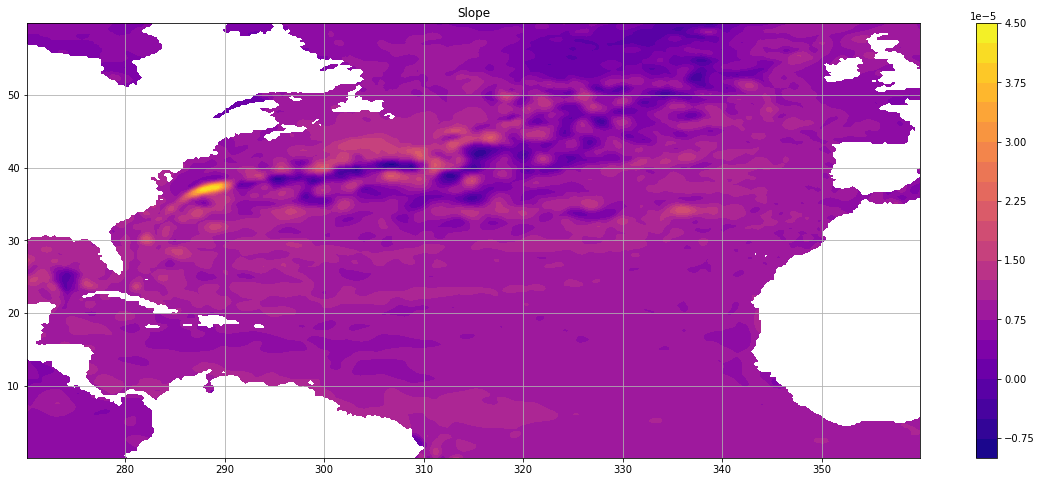

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
CS=ax.contourf(Trend.longitude,Trend.latitude,Trend.slope,20,cmap='plasma')
ax.set_title('Slope')
ax.grid()
fig.colorbar(CS);

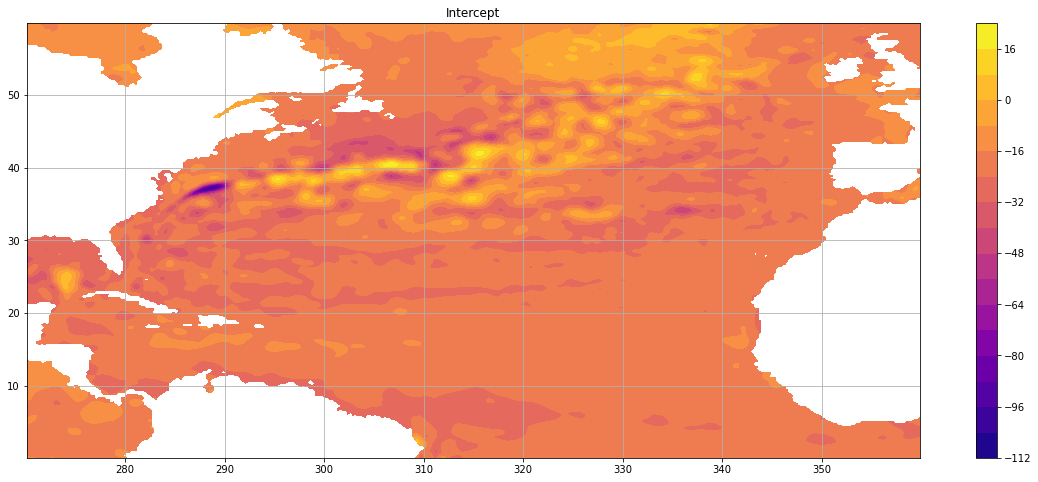

In [14]:
fig, ax = plt.subplots(figsize=(20,8))
CS=ax.contourf(Trend.longitude,Trend.latitude,Trend.intercept,20,cmap='plasma')
ax.set_title('Intercept')
ax.grid()
fig.colorbar(CS);

### Compute the time series of the trend to substract from the original times series

In [15]:
np_Time = sla.time.to_pandas().index.to_julian_date().values
np_Slope = Trend.slope.values
np_Inter = Trend.intercept.values

In [16]:
sla

<xarray.DataArray 'sla' (time: 1409, latitude: 240, longitude: 360)>
array([[[ 0.0403,  0.0379, ..., -0.0293, -0.0284],
        [ 0.0434,  0.0399, ..., -0.0273, -0.0269],
        ...,
        [    nan,     nan, ...,  0.0726,  0.0815],
        [    nan,     nan, ...,  0.0533,  0.059 ]],

       [[ 0.0344,  0.0323, ..., -0.0104, -0.0111],
        [ 0.0359,  0.0347, ..., -0.011 , -0.0112],
        ...,
        [    nan,     nan, ...,  0.2213,  0.239 ],
        [    nan,     nan, ...,  0.2295,  0.2509]],

       ...,

       [[ 0.0801,  0.0805, ...,  0.1299,  0.1273],
        [ 0.0815,  0.0824, ...,  0.1312,  0.1289],
        ...,
        [    nan,     nan, ...,  0.0603,  0.0392],
        [    nan,     nan, ...,  0.0619,  0.0442]],

       [[ 0.1204,  0.1221, ...,  0.1193,  0.1205],
        [ 0.1262,  0.1285, ...,  0.1114,  0.1126],
        ...,
        [    nan,     nan, ...,  0.1412,  0.1403],
        [    nan,     nan, ...,  0.1457,  0.1464]]])
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * longitude  (longitude) float32 270.1 270.4 270.6 270.9 ... 359.4 359.6 359.9
Attributes:
    comment:        The sea level anomaly is the sea surface height above mea...
    grid_mapping:   crs
    long_name:      Sea level anomaly
    standard_name:  sea_surface_height_above_sea_level
    units:          m

In [17]:
np_Trend = np_Slope[:,:,None] * np_Time + np_Inter[:,:,None]

In [18]:
np_Trend.shape

(240, 360, 1409)

In [19]:
np_Trend = np.swapaxes(np.swapaxes(np_Trend,0,2),1,2)

In [20]:
sla_detrend=sla-np_Trend

In [21]:
sla_detrend

<xarray.DataArray 'sla' (time: 1409, latitude: 240, longitude: 360)>
array([[[ 0.03178185,  0.02947179,  0.02774601, ..., -0.02245795,
         -0.02285084, -0.02213785],
        [ 0.03590225,  0.03249769,  0.02967942, ..., -0.02021051,
         -0.02088437, -0.02065368],
        [ 0.03830381,  0.03449335,  0.03153866, ..., -0.01947722,
         -0.02026557, -0.02053391],
        ...,
        [        nan,         nan,         nan, ...,  0.07688519,
          0.0887476 ,  0.09571631],
        [        nan,         nan,         nan, ...,  0.06324265,
          0.07246082,  0.08112261],
        [        nan,         nan,         nan, ...,  0.05145008,
          0.05369762,  0.05924115]],

       [[ 0.02583701,  0.02382674,  0.02350067, ..., -0.00332146,
         -0.004014  , -0.00490068],
        [ 0.02835579,  0.02725099,  0.02773256, ..., -0.00487419,
         -0.00464776, -0.00501677],
        [ 0.03095614,  0.02984541,  0.03059068, ..., -0.00824111,
         -0.00672921, -0.00619727],
...
        [        nan,         nan,         nan, ...,  0.02241855,
         -0.00250306, -0.02311692],
        [        nan,         nan,         nan, ...,  0.00869223,
         -0.01315059, -0.03350321],
        [        nan,         nan,         nan, ...,  0.00527049,
         -0.01120536, -0.02810499]],

       [[ 0.0487383 ,  0.05024887,  0.05141616, ...,  0.03472381,
          0.03681777,  0.03830727],
        [ 0.05328853,  0.05534376,  0.05639517, ...,  0.02703557,
          0.02855612,  0.03001784],
        [ 0.05549726,  0.05758514,  0.05778625, ...,  0.02077218,
          0.02173002,  0.02316521],
        ...,
        [        nan,         nan,         nan, ...,  0.0713652 ,
          0.06674446,  0.06633117],
        [        nan,         nan,         nan, ...,  0.06943882,
          0.0676973 ,  0.06754538],
        [        nan,         nan,         nan, ...,  0.07071685,
          0.0725424 ,  0.07404345]]])
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * longitude  (longitude) float32 270.1 270.4 270.6 270.9 ... 359.4 359.6 359.9
Attributes:
    comment:        The sea level anomaly is the sea surface height above mea...
    grid_mapping:   crs
    long_name:      Sea level anomaly
    standard_name:  sea_surface_height_above_sea_level
    units:          m

### Represent Time series and trend

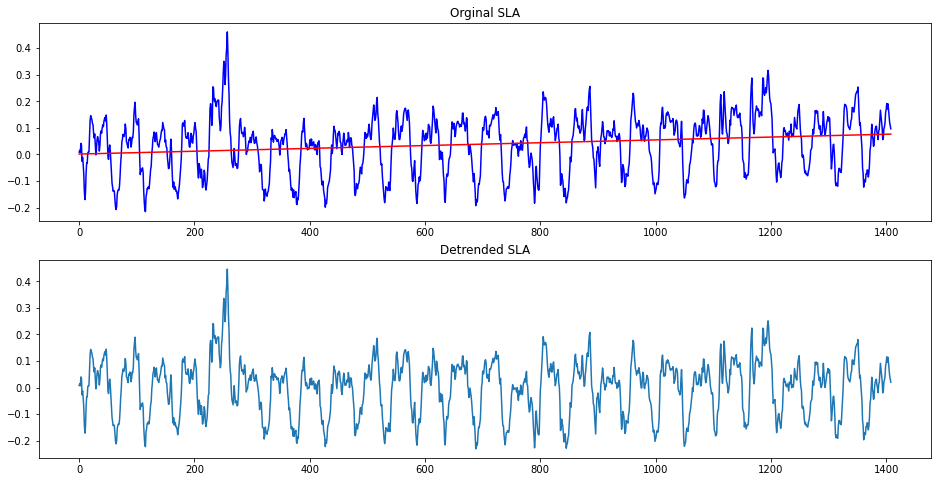

In [22]:
fig, ax = plt.subplots(2,1,figsize=(16,8))

ax[0].plot(sla[:,20,40],'b')
ax[0].plot(np_Trend[:,20,40],'r')                       
ax[0].set_title('Orginal SLA')
                       
ax[1].plot(sla_detrend[:,20,40])
ax[1].set_title('Detrended SLA');

## Compute anomalies
### First compute montly climatology

In [23]:
sla_clim = sla_detrend.groupby('time.month').mean(dim='time')
sla_clim

<xarray.DataArray 'sla' (month: 12, latitude: 240, longitude: 360)>
array([[[ 2.43301271e-03,  1.77351238e-03,  7.98322620e-04, ...,
          1.17473088e-02,  1.14809074e-02,  1.11843222e-02],
        [ 2.79647086e-03,  2.09054133e-03,  1.18591610e-03, ...,
          1.04024491e-02,  1.01803924e-02,  9.87628205e-03],
        [ 2.99008188e-03,  2.41425947e-03,  1.81394828e-03, ...,
          8.58302922e-03,  8.49219940e-03,  8.22878449e-03],
        ...,
        [-2.38524770e-01, -2.38583525e-01, -1.39695009e-01, ...,
          1.78946159e-02,  1.53470666e-02,  1.36712215e-02],
        [            nan,             nan, -2.37386147e-02, ...,
          2.04470667e-02,  1.89247597e-02,  1.78506243e-02],
        [            nan,             nan, -1.75822393e-02, ...,
          2.48230229e-02,  2.39845266e-02,  2.33480458e-02]],

       [[-4.30178922e-03, -5.98641948e-03, -7.69841202e-03, ...,
          2.62866843e-02,  2.65987399e-02,  2.67098054e-02],
        [-5.92349007e-03, -7.63865792e-03, -9.37366117e-03, ...,
          2.50945912e-02,  2.53146182e-02,  2.53579366e-02],
        [-8.06730784e-03, -9.68159666e-03, -1.13596457e-02, ...,
          2.34458101e-02,  2.35452900e-02,  2.35119728e-02],
...
        [ 8.52100333e-03,  9.37128900e-03,  1.09161282e-02, ...,
          5.51959143e-02,  4.92554221e-02,  4.38860714e-02],
        [ 1.03004795e-02,  1.13375231e-02,  1.27539372e-02, ...,
          5.91519842e-02,  5.39288051e-02,  4.90935622e-02],
        [ 1.01528268e-02,  1.12632272e-02,  1.29054714e-02, ...,
          6.41690079e-02,  6.04813531e-02,  5.67904607e-02]],

       [[ 1.59103225e-02,  1.60135073e-02,  1.61425472e-02, ...,
          1.65655837e-03,  1.24380556e-03,  9.23322009e-04],
        [ 1.78062578e-02,  1.79422338e-02,  1.80989176e-02, ...,
          1.87454325e-03,  1.46698287e-03,  1.14682212e-03],
        [ 1.92446832e-02,  1.94384003e-02,  1.96594833e-02, ...,
          2.22808750e-03,  1.88058478e-03,  1.60069718e-03],
        ...,
        [-8.92683722e-03, -7.96376903e-03,  2.21137264e-04, ...,
          5.47970854e-02,  5.24922004e-02,  5.03567305e-02],
        [-6.99409781e-03, -5.16610845e-03,  6.56199923e-03, ...,
          5.60000923e-02,  5.39875002e-02,  5.20843266e-02],
        [-6.46845326e-03, -4.27650613e-03,  8.34633124e-03, ...,
          5.86210687e-02,  5.68947967e-02,  5.51236775e-02]]])
Coordinates:
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * longitude  (longitude) float32 270.1 270.4 270.6 270.9 ... 359.4 359.6 359.9
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:        The sea level anomaly is the sea surface height above mea...
    grid_mapping:   crs
    long_name:      Sea level anomaly
    standard_name:  sea_surface_height_above_sea_level
    units:          m

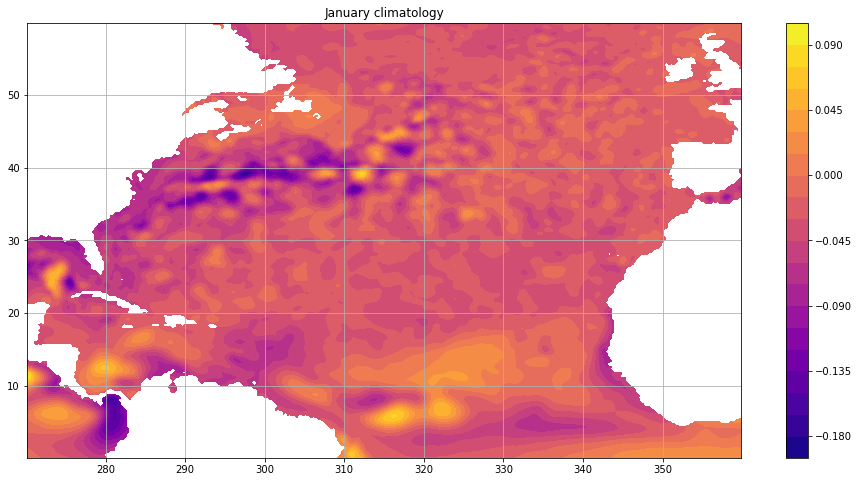

In [24]:
fig, ax = plt.subplots(figsize=(16,8))
CS=ax.contourf(sla_clim.longitude,sla_clim.latitude,sla_clim.isel(month=1),20,cmap='plasma')
ax.set_title('January climatology')
ax.grid()
fig.colorbar(CS);

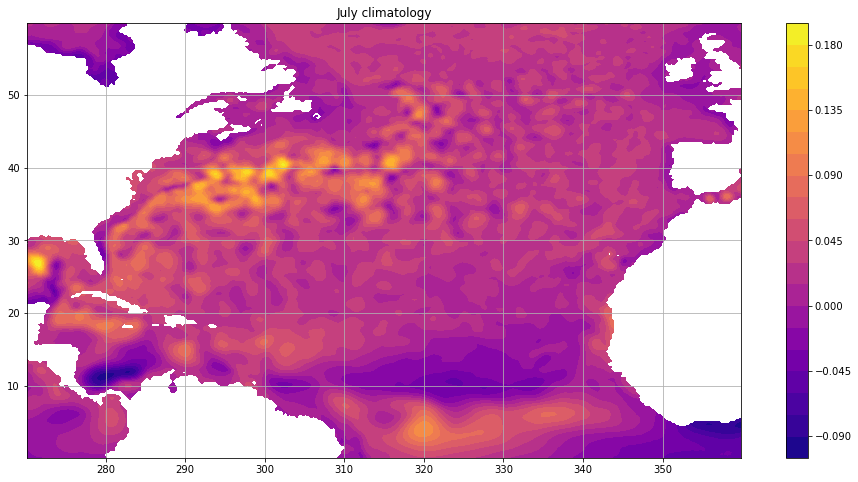

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
CS=ax.contourf(sla_clim.longitude,sla_clim.latitude,sla_clim.isel(month=7),20,cmap='plasma')
ax.set_title('July climatology')
ax.grid()
fig.colorbar(CS);

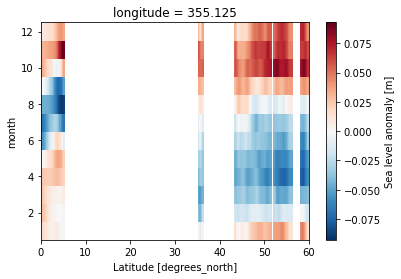

In [35]:
sla_clim.isel(longitude=340).plot()

## Compute anomalies

In [36]:
sla_anom = (sla_detrend.groupby('time.month') - sla_clim)
sla_anom

<xarray.DataArray 'sla' (time: 1409, latitude: 240, longitude: 360)>
array([[[ 0.02934884,  0.02769828,  0.02694769, ..., -0.03420526,
         -0.03433175, -0.03332218],
        [ 0.03310577,  0.03040715,  0.0284935 , ..., -0.03061296,
         -0.03106476, -0.03052997],
        [ 0.03531372,  0.03207909,  0.02972471, ..., -0.02806025,
         -0.02875777, -0.0287627 ],
        ...,
        [        nan,         nan,         nan, ...,  0.05899058,
          0.07340053,  0.08204509],
        [        nan,         nan,         nan, ...,  0.04279559,
          0.05353606,  0.06327198],
        [        nan,         nan,         nan, ...,  0.02662706,
          0.0297131 ,  0.03589311]],

       [[ 0.02340399,  0.02205323,  0.02270235, ..., -0.01506877,
         -0.01549491, -0.016085  ],
        [ 0.02555932,  0.02516045,  0.02654664, ..., -0.01527664,
         -0.01482815, -0.01489305],
        [ 0.02796606,  0.02743115,  0.02877673, ..., -0.01682414,
         -0.01522141, -0.01442605],
...
        [        nan,         nan,         nan, ..., -0.03237853,
         -0.05499526, -0.07347365],
        [        nan,         nan,         nan, ..., -0.04730786,
         -0.06713809, -0.08558754],
        [        nan,         nan,         nan, ..., -0.05335058,
         -0.06810015, -0.08322867]],

       [[ 0.03282798,  0.03423536,  0.03527362, ...,  0.03306726,
          0.03557396,  0.03738394],
        [ 0.03548227,  0.03740152,  0.03829625, ...,  0.02516102,
          0.02708914,  0.02887102],
        [ 0.03625258,  0.03814674,  0.03812677, ...,  0.0185441 ,
          0.01984943,  0.02156452],
        ...,
        [        nan,         nan,         nan, ...,  0.01656811,
          0.01425226,  0.01597444],
        [        nan,         nan,         nan, ...,  0.01343873,
          0.0137098 ,  0.01546106],
        [        nan,         nan,         nan, ...,  0.01209578,
          0.01564761,  0.01891977]]])
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * longitude  (longitude) float32 270.1 270.4 270.6 270.9 ... 359.4 359.6 359.9
    month      (time) int64 1 1 1 1 1 2 2 2 2 3 ... 11 11 11 11 11 12 12 12 12
Attributes:
    comment:        The sea level anomaly is the sea surface height above mea...
    grid_mapping:   crs
    long_name:      Sea level anomaly
    standard_name:  sea_surface_height_above_sea_level
    units:          m

### Represent anomalies

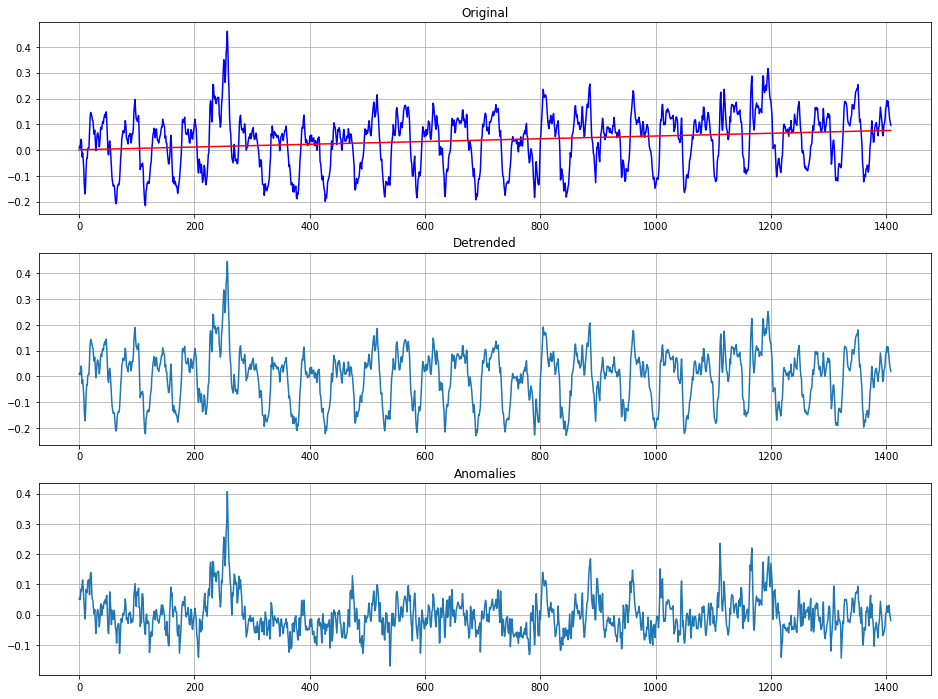

In [37]:
fig, ax = plt.subplots(3,figsize=(16,12))

ax[0].plot(sla[:,20,40],'b')
ax[0].plot(np_Trend[:,20,40],'r')                       
ax[0].set_title('Original')
ax[0].grid()

ax[1].plot(sla_detrend[:,20,40])
ax[1].set_title('Detrended')
ax[1].grid()

ax[2].plot(sla_anom[:,20,40])
ax[2].set_title('Anomalies');
ax[2].grid();

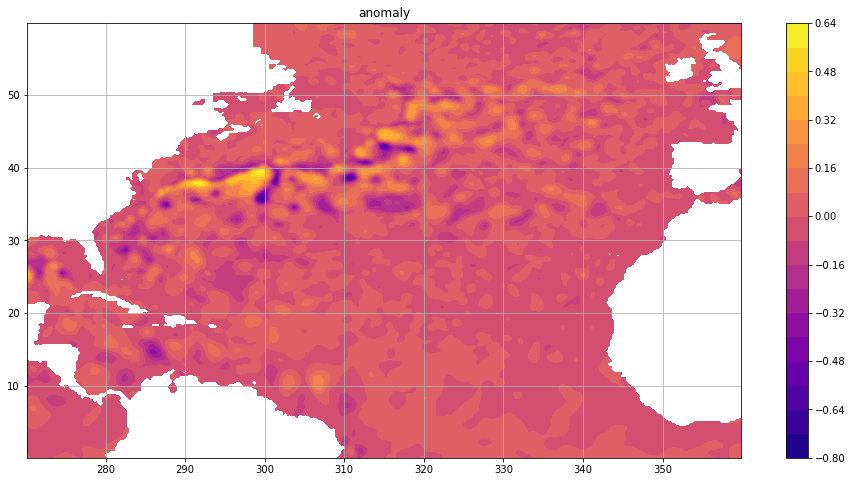

In [38]:
fig, ax = plt.subplots(figsize=(16,8))
CS=ax.contourf(sla_anom.longitude,sla_anom.latitude,sla_anom.isel(time=1000),20,cmap='plasma')
ax.set_title('anomaly')
ax.grid()
fig.colorbar(CS);

### Save data

In [39]:
ds['sla_detrend']=sla_detrend
ds['sla_anom']=sla_anom

In [40]:
ds=ds.drop('month')
ds

<xarray.Dataset>
Dimensions:      (latitude: 240, longitude: 360, time: 1409)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude     (latitude) float32 0.125 0.375 0.625 ... 59.38 59.62 59.88
  * longitude    (longitude) float32 270.1 270.4 270.6 ... 359.4 359.6 359.9
Data variables:
    sla          (time, latitude, longitude) float64 0.0403 0.0379 ... 0.1464
    sla_detrend  (time, latitude, longitude) float64 0.03178 0.02947 ... 0.07404
    sla_anom     (time, latitude, longitude) float64 0.02935 0.0277 ... 0.01892

#### Establecer nuevo atributo corrección

In [41]:
ds.sla.attrs['correction level']='None'
ds.sla_detrend.attrs['correction level']='Linear trend'
ds.sla_anom.attrs['correction level']='Linear trend and seasonal anomaly'

#### Reducir tamaño archivo

In [42]:
ds.sla_detrend.encoding={k:v for k,v in ds.sla.encoding.items() if k in {'_FillValue','add_offset','dtype','scale_factor','engine'}}
ds.sla_anom.encoding={k:v for k,v in ds.sla.encoding.items() if k in {'_FillValue','add_offset','dtype','scale_factor','engine'}}

#### Cargar datos (necesario para poder guardalos)

In [43]:
ds.load()

<xarray.Dataset>
Dimensions:      (latitude: 240, longitude: 360, time: 1409)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude     (latitude) float32 0.125 0.375 0.625 ... 59.38 59.62 59.88
  * longitude    (longitude) float32 270.1 270.4 270.6 ... 359.4 359.6 359.9
Data variables:
    sla          (time, latitude, longitude) float64 0.0403 0.0379 ... 0.1464
    sla_detrend  (time, latitude, longitude) float64 0.03178 0.02947 ... 0.07404
    sla_anom     (time, latitude, longitude) float64 0.02935 0.0277 ... 0.01892

In [44]:
ds.to_netcdf('sla_NorthAtlantic7D_corrected.nc')